# Time Series Analysis on Nondurable Goods Sales


In this project we will analyse sales of Nondurable Goods such as Beer, Wine, and Distilled Alcoholic Beverages over duration of time.

## Outline

- [ 1 - Packages](#1)
- [ 2 - Sales dataset](#2)
- [ 3 - Forecasting Method](#3)
    - [ 3.1 - Holt Winters Method](#3.1)
    - [ 3.2 - ARIMA Model](#3.2)
    - [ 3.3 - SARIMA Model](#3.3)
    - [ 3.4 - RNN Model](#3.4)
- [ 4 - Model Selection and Future Forecast](#4)

<a name="1"></a>
## 1 - Packages 

In [1]:
# import library
import pandas as pd
import numpy as np

# plot library
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import month_plot, quarter_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#descriptive test
from statsmodels.tsa.stattools import adfuller

from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator

from statsmodels.tsa.statespace.tools import diff
from pmdarima.arima import auto_arima

# models library
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima_model import ARIMA, ARIMAResults
from statsmodels.tsa.statespace.sarimax import SARIMAX

#RNN
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# evaluation
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import mean_squared_error

In [2]:
# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

<a name="2"></a>
## 2 - Sales Dataset

Units for Sales:  Millions of Dollars

Frequency:  Monthly

Suggested Citation:

U.S. Census Bureau, Merchant Wholesalers, Except Manufacturers' Sales Branches and Offices: Nondurable Goods: Beer, Wine, and Distilled Alcoholic Beverages Sales [S4248SM144NCEN], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/S4248SM144NCEN, May 3, 2024.

In [3]:
# Import data
df = pd.read_csv('Sales_Data.csv', index_col='DATE', parse_dates=True)
df.head()

,S4248SM144NCEN
DATE,
1992-01-01,3459.0
1992-02-01,3458.0
1992-03-01,4002.0
1992-04-01,4564.0
1992-05-01,4221.0


In [4]:
df.index.freq = 'MS'

In [5]:
df.columns = ['Sales']

In [6]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Sales,386.0,8960.709845,3755.837173,3031.0,5592.5,8664.5,11473.0,18222.0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 386 entries, 1992-01-01 to 2024-02-01
Freq: MS
Data columns (total 1 columns):
Sales    386 non-null float64
dtypes: float64(1)
memory usage: 6.0 KB


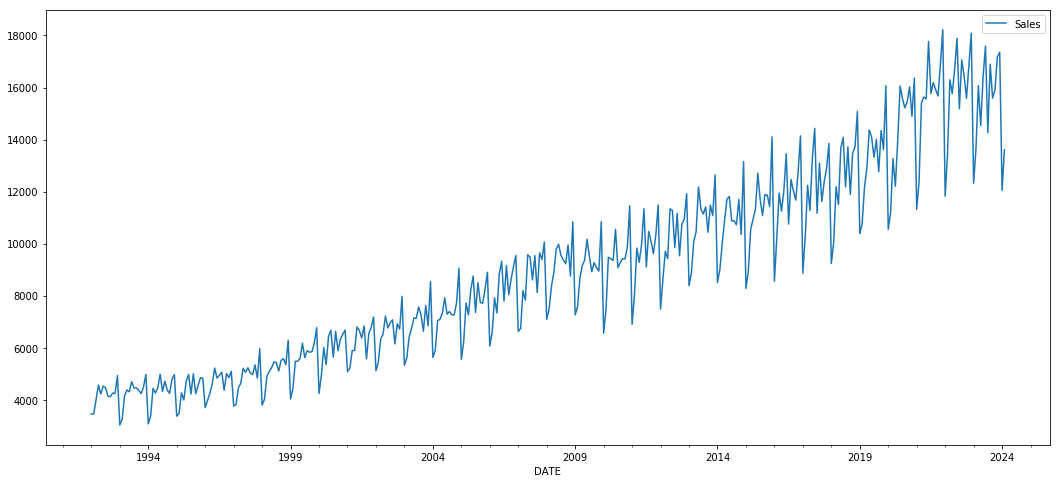

In [8]:
df.plot(figsize=(18,8))

In [9]:
# view each time series component seperately

results = seasonal_decompose(df['Sales'])

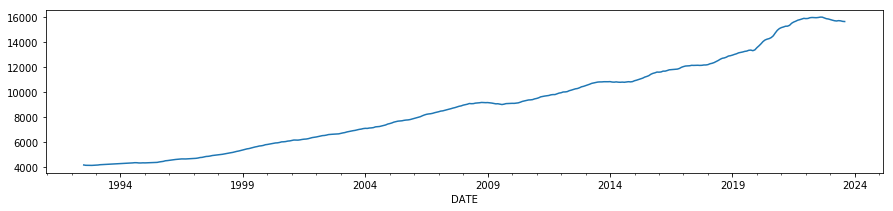

In [10]:
# TREND
results.trend.plot(figsize=(15,3))

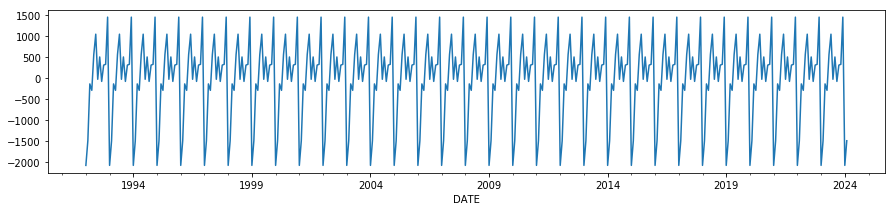

In [11]:
# SEASONAL
results.seasonal.plot(figsize=(15,3))

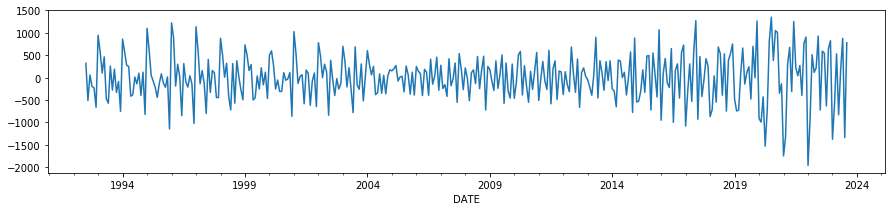

In [12]:
# ERROR
results.resid.plot(figsize=(15,3))

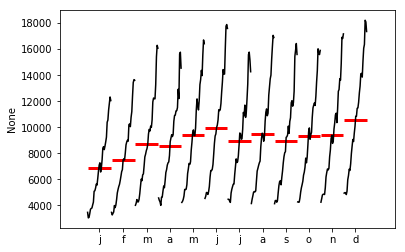

In [13]:
# MONTHLY PLOT
month_plot(df);

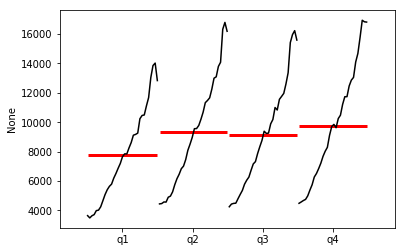

In [14]:
# QUARTER PLOT
df_q = df['Sales'].resample(rule='Q').mean()

quarter_plot(df_q);

<a name="3"></a>
## 3 - Forecasting

** TRAIN - TEST SPLIT **

In [16]:
# LEN OF DF
len(df)

386

In [17]:
# LAST 12 MONTHS
len(df)-12

374

In [18]:
train = df.iloc[:374]
test = df.iloc[374:]

In [19]:
test

,Sales
DATE,
2023-03-01,16074.0
2023-04-01,14542.0
2023-05-01,16419.0
2023-06-01,17592.0
2023-07-01,14265.0
2023-08-01,16896.0
2023-09-01,15593.0
2023-10-01,15903.0
2023-11-01,17173.0


<a name="3.1"></a>
### 3.1 - Forecasting with the Holt-Winters Method

Holt-Winters forecasting model is a moving average model, here we forecast the variable of interest using a linear combination of predictors.

In [48]:
# FIT THE MODEL WITH HOLT_WINTERS METHOD
model = ExponentialSmoothing(train['Sales'], trend='mul',seasonal='add', seasonal_periods=12)
fitted_model = model.fit()

In [49]:
# FORECAST FOR NEXT 12 MONTHS
test_forecast = fitted_model.forecast(12).rename('HW Forecast')
test_forecast

2023-03-01    16379.199299
2023-04-01    16029.046397
2023-05-01    16991.202368
2023-06-01    18366.211097
2023-07-01    16414.262653
2023-08-01    17446.897327
2023-09-01    16877.336908
2023-10-01    16852.671037
2023-11-01    17460.304523
2023-12-01    18890.065571
2024-01-01    13278.309474
2024-02-01    14648.269107
Freq: MS, Name: HW Forecast, dtype: float64

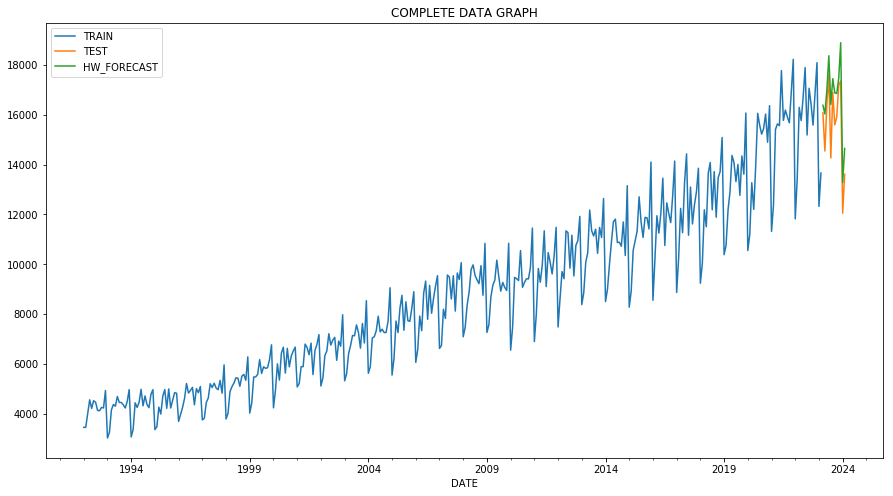

In [50]:
title = 'COMPLETE DATA GRAPH'
train['Sales'].plot(legend=True,label='TRAIN')
test['Sales'].plot(legend=True,label='TEST',figsize=(15,8))
test_forecast.plot(legend=True,label='HW_FORECAST', title=title)

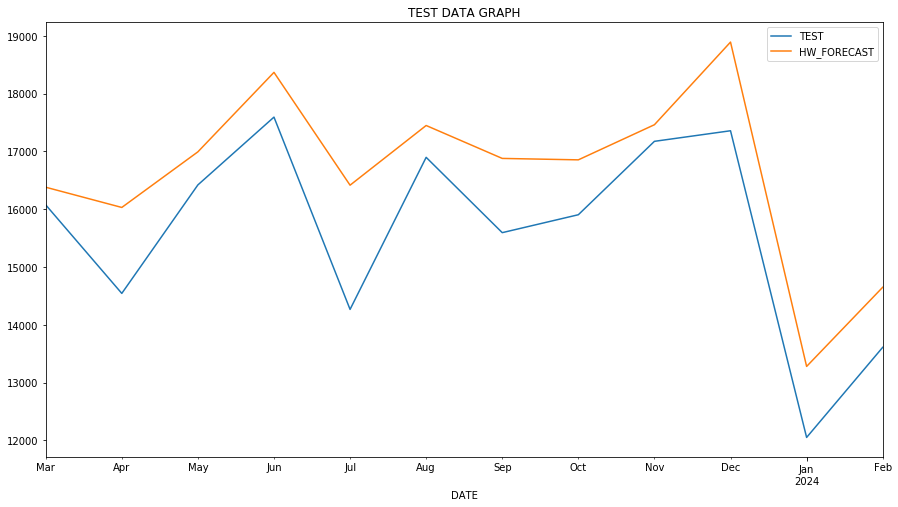

In [51]:
title = 'TEST DATA GRAPH'
test['Sales'].plot(legend=True,label='TEST',figsize=(15,8))
test_forecast.plot(legend=True,label='HW_FORECAST', xlim=['2023-03-01','2024-02-01'], title=title)

In [52]:
hw_error = rmse(test['Sales'], test_forecast)
print(f'Holt Winters RMSE Error: {hw_error:11.10}')

Holt Winters RMSE Error: 1144.924003


<a name="3.2"></a>
### 3.2 - Forecasting with ARIMA Models

ARIMA, or Autoregressive Integrated Moving Average is actually a combination of 3 models:

- AR(p) Autoregression - a regression model that utilizes the dependent relationship between a current observation and observations over a previous period
- I(d) Integration - uses differencing of observations (subtracting an observation from an observation at the previous time step) in order to make the time series stationary
- MA(q) Moving Average - a model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.


#### Let's try to find values for p,d and q

**METHOD 1: PLOT**

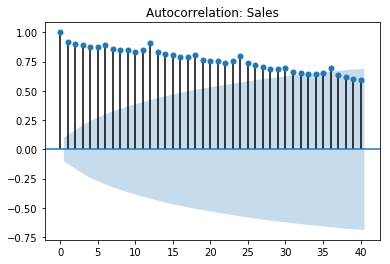

In [60]:
# ACF PLOT
title = 'Autocorrelation: Sales'
lags = 40
plot_acf(df,title=title, lags=lags);

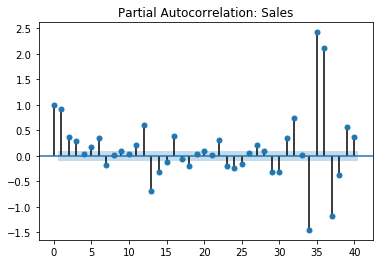

In [59]:
# PACF PLOT
title = 'Partial Autocorrelation: Sales'
lags = 40
plot_pacf(df,title=title,lags=lags);

We can read the graph to find values for p, and q

In [64]:
## Integration VALUE- Augmented Dickey-Fuller Test

# To determine whether a series is stationary

dftest = adfuller(df['Sales'],autolag='AIC')
dftest

(0.40762776062866635,
 0.981777961830674,
 17,
 368,
 {'1%': -3.4482453822848496,
  '5%': -2.8694261442901396,
  '10%': -2.5709711770439507},
 5559.6349812629205)

Here we have a very high p-value at 0.98, which provides weak evidence against the null hypothesis, and so we <em>fail to reject</em> the null hypothesis, and decide that our dataset is not stationary.<br>

In [71]:
# DIFFERENCING - make df Stationary
df_0 = df.copy()

In [77]:
df['d1'] = diff(df['Sales'], k_diff=1)

dftest = adfuller(df['d1'].dropna(), autolag='AIC')
dftest

(-3.561504616823278,
 0.0065410877113478,
 17,
 367,
 {'1%': -3.448294490928673,
  '5%': -2.869447722240253,
  '10%': -2.570982681065269},
 5542.236221104078)

Here we have a very high p-value at 0.006, which provides strong evidence against the null hypothesis, and so we <em> reject</em> the null hypothesis, and conclude our dataset is stationary after 1 order differencing.<br>

** METHOD 2: GRID SEARCH**

In [79]:
# USE AUTO ARIMA
auto_arima(df['Sales'],seasonal=False).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  386
Model:               SARIMAX(4, 1, 2)   Log Likelihood               -3231.046
Date:                Wed, 08 May 2024   AIC                           6478.091
Time:                        08:14:33   BIC                           6509.717
Sample:                             0   HQIC                          6490.634
                                - 386                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     16.6072      6.685      2.484      0.013       3.505      29.710
ar.L1          0.8522      0.049     17.406      0.000       0.756       0.948
ar.L2         -0.2165      0.074     -2.930      0.003      -0.361      -0.072
ar.L3          0.0564      0.106      0.535      0.593      -0.150       0.263
ar.L4         -0.2597      0.076     -3.434      0.001      -0.408      -0.111
ma.L1         -1.8222      0.030    -60.978      0.000      -1.881      -1.764
ma.L2          0.8921      0.029     31.142      0.000       0.836       0.948
sigma2      1.278e+06   8.26e+04     15.474      0.000    1.12e+06    1.44e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.89   Jarque-Bera (JB):                41.12
Prob(Q):                              0.35   Prob(JB):                         0.00
Heteroskedasticity (H):               7.06   Skew:                            -0.04
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [106]:
# Fit an ARIMA(p,q) Model
model = ARIMA(train['Sales'], order=(4, 1, 2))
fitted_model = model.fit()
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Sales   No. Observations:                  373
Model:                 ARIMA(4, 1, 2)   Log Likelihood               -3119.546
Method:                       css-mle   S.D. of innovations           1031.549
Date:                Wed, 08 May 2024   AIC                           6255.093
Time:                        08:55:26   BIC                           6286.465
Sample:                    02-01-1992   HQIC                          6267.550
                         - 02-01-2023                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            31.5712      7.079      4.460      0.000      17.697      45.445
ar.L1.D.Sales     0.9198      0.056     16.375      0.000       0.810       1.030
ar.L2.D.Sales    -0.2527      0.069     -3.640      0.000      -0.389      -0.117
ar.L3.D.Sales     0.0619      0.071      0.877      0.381      -0.076       0.200
ar.L4.D.Sales    -0.2402      0.055     -4.329      0.000      -0.349      -0.131
ma.L1.D.Sales    -1.8479      0.029    -63.925      0.000      -1.905      -1.791
ma.L2.D.Sales     0.9155      0.027     33.926      0.000       0.863       0.968
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.9877           -0.6045j            1.1580           -0.0874
AR.2            0.9877           +0.6045j            1.1580            0.0874
AR.3           -0.8589           -1.5385j            1.7620           -0.3310
AR.4           -0.8589           +1.5385j            1.7620            0.3310
MA.1            1.0093           -0.2715j            1.0451           -0.0418
MA.2            1.0093           +0.2715j            1.0451            0.0418
-----------------------------------------------------------------------------
"""

In [107]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
predictions = fitted_model.predict(start=start, end=end, dynamic=False, typ='levels').rename('ARIMA Predictions')

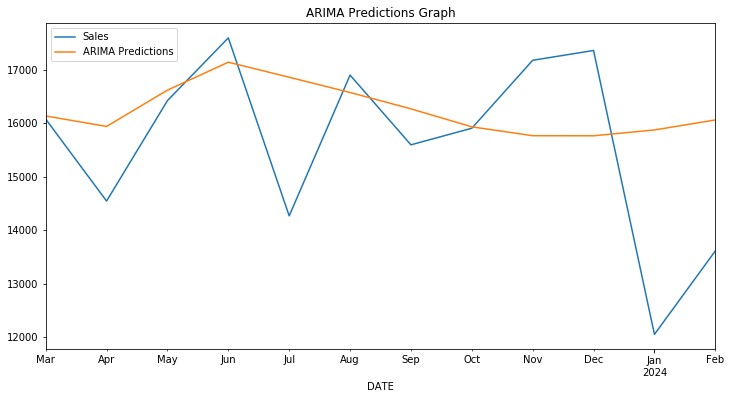

In [108]:
# Plot predictions against known values
title = 'ARIMA Predictions Graph'

ax = test['Sales'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)

In [109]:
error = rmse(test['Sales'], predictions)
print(f'ARIMA RMSE Error: {error:11.10}')

ARIMA RMSE Error: 1697.764636


<a name="3.3"></a>
### 3.3 - Forecasting with SARIMA Models

Let's consider seasonality in data as well for prediction

In [100]:
auto_arima(df['Sales'],seasonal=True,m=12, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=2.10 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=6717.424, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=inf, Time=0.82 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=6201.187, Time=1.01 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=6715.548, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=6529.538, Time=0.16 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=5903.329, Time=1.61 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=5896.110, Time=1.05 sec
 ARIMA(0,1,1)(2,0,0)[12] intercept   : AIC=5907.638, Time=3.05 sec
 ARIMA(0,1,1)(2,0,1)[12] intercept   : AIC=inf, Time=4.82 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=inf, Time=0.35 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=6116.736, Time=1.24 sec
 ARIMA(0,1,2)(1,0,0)[12] intercept   : AIC=5971.923, Time=1.36 sec
 ARIMA(1,1,2)(1,0,0)[12] intercept   : AIC=inf, Time=1.73 sec
 ARIMA(0,1,1)(1,0,0)[12]             : AIC=i

ARIMA(order=(0, 1, 1), scoring_args={}, seasonal_order=(1, 0, 0, 12),
      suppress_warnings=True)

In [46]:
auto_arima(df['Sales'],seasonal=True,m=12).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  386
Model:             SARIMAX(0, 1, 1)x(1, 0, [], 12)   Log Likelihood               -2944.055
Date:                             Wed, 08 May 2024   AIC                           5896.110
Time:                                     10:45:52   BIC                           5911.923
Sample:                                          0   HQIC                          5902.381
                                             - 386                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.3545      2.707      0.500      0.617      -3.951       6.660
ma.L1         -0.8256      0.022    -38.150      0.000      -0.868      -0.783
ar.S.L12       0.9111      0.019     46.964      0.000       0.873       0.949
sigma2      2.343e+05   1.23e+04     19.114      0.000     2.1e+05    2.58e+05
===================================================================================
Ljung-Box (L1) (Q):                   1.56   Jarque-Bera (JB):                53.09
Prob(Q):                              0.21   Prob(JB):                         0.00
Heteroskedasticity (H):               4.90   Skew:                             0.24
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [53]:
model = SARIMAX(train['Sales'], orders=(0, 1, 1), seasonal_orders=(1, 0, 0, 12))
fitted_model = model.fit()
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Sales   No. Observations:                  374
Model:               SARIMAX(1, 0, 0)   Log Likelihood               -3252.615
Date:                Wed, 08 May 2024   AIC                           6509.230
Time:                        10:46:49   BIC                           6517.078
Sample:                    01-01-1992   HQIC                          6512.346
                         - 02-01-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9886      0.008    126.199      0.000       0.973       1.004
sigma2       2.08e+06   1.29e+05     16.184      0.000    1.83e+06    2.33e+06
===================================================================================
Ljung-Box (L1) (Q):                  58.73   Jarque-Bera (JB):               372.97
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               7.43   Skew:                            -1.57
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [54]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
predictions = fitted_model.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMA Predictions')

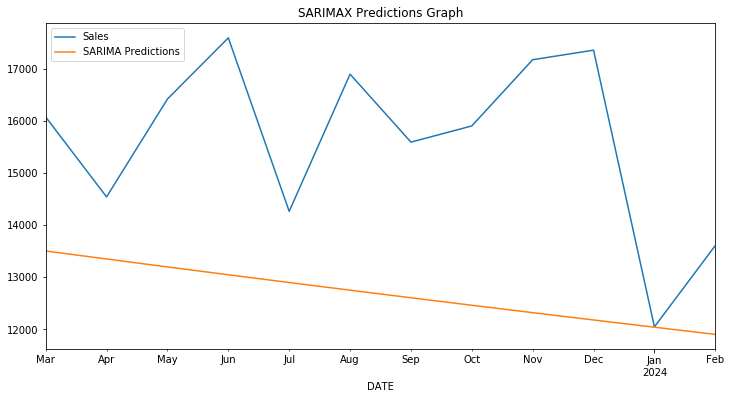

In [55]:
# Plot predictions against known values
title = 'SARIMAX Predictions Graph'

ax = test['Sales'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)

In [56]:
error = rmse(test['Sales'], predictions)
print(f'SARIMA RMSE Error: {error:11.10}')

SARIMA RMSE Error: 3316.509326


<a name="3.4"></a>
### 3.4 - Forecasting with RNN

In [113]:
df = df_0.copy()

In [114]:
df.head()

,Sales
DATE,
1992-01-01,3459.0
1992-02-01,3458.0
1992-03-01,4002.0
1992-04-01,4564.0
1992-05-01,4221.0


In [115]:
df.tail()

,Sales
DATE,
2023-10-01,15903.0
2023-11-01,17173.0
2023-12-01,17356.0
2024-01-01,12050.0
2024-02-01,13609.0


In [21]:
# SCALE the data
scaler = MinMaxScaler()
scaler.fit(train)

MinMaxScaler()

In [22]:
train_scaled = scaler.transform(train)
test_scaled = scaler.transform(test)

In [24]:
# Generator - to feed NN in proper format

n_input = 12 # yearly seasonality
n_features = 1   # one output feature
generator = TimeseriesGenerator(train_scaled,train_scaled,length=n_input,batch_size=1) # keep batch size as 1

In [25]:
X,y = generator[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.02817458 0.02810875 0.06391943 0.10091502 0.07833586 0.09861102
 0.09446383 0.07280627 0.07208215 0.08083734 0.0795866  0.1254032 ]
Predict this y: 
 [[0.]]


In [26]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               40800     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [28]:
# fit model
model.fit_generator(generator,epochs=50)

Epoch 1/50
362/362 [==============================] - ETA: 0s - loss: 0.016 - 7s 10ms/step - loss: 0.0163
Epoch 2/50
362/362 [==============================] - 4s 10ms/step - loss: 0.0082
Epoch 3/50
362/362 [==============================] - 4s 10ms/step - loss: 0.0065
Epoch 4/50
362/362 [==============================] - 4s 10ms/step - loss: 0.0070
Epoch 5/50
362/362 [==============================] - 3s 9ms/step - loss: 0.0064
Epoch 6/50
362/362 [==============================] - 3s 10ms/step - loss: 0.0061
Epoch 7/50
362/362 [==============================] - 4s 10ms/step - loss: 0.0061
Epoch 8/50
362/362 [==============================] - 3s 9ms/step - loss: 0.0054
Epoch 9/50
362/362 [==============================] - 3s 9ms/step - loss: 0.0045
Epoch 10/50
362/362 [==============================] - 3s 10ms/step - loss: 0.0032
Epoch 11/50
362/362 [==============================] - 3s 9ms/step - loss: 0.0034
Epoch 12/50
362/362 [==============================] - 3s 9ms/step - loss: 0

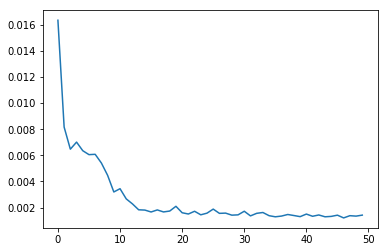

In [29]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [31]:
test_predictions = []

first_eval_batch = train_scaled[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [33]:
test_predictions

[array([0.9015162], dtype=float32),
 array([0.8887278], dtype=float32),
 array([0.94170773], dtype=float32),
 array([0.9958013], dtype=float32),
 array([0.8769101], dtype=float32),
 array([0.96121013], dtype=float32),
 array([0.9304811], dtype=float32),
 array([0.895061], dtype=float32),
 array([0.95412755], dtype=float32),
 array([1.0079548], dtype=float32),
 array([0.71836793], dtype=float32),
 array([0.7976227], dtype=float32)]

In [34]:
# convert to get true prediction
true_predictions = scaler.inverse_transform(test_predictions)

In [35]:
test['rnn_prediction_1'] =  true_predictions

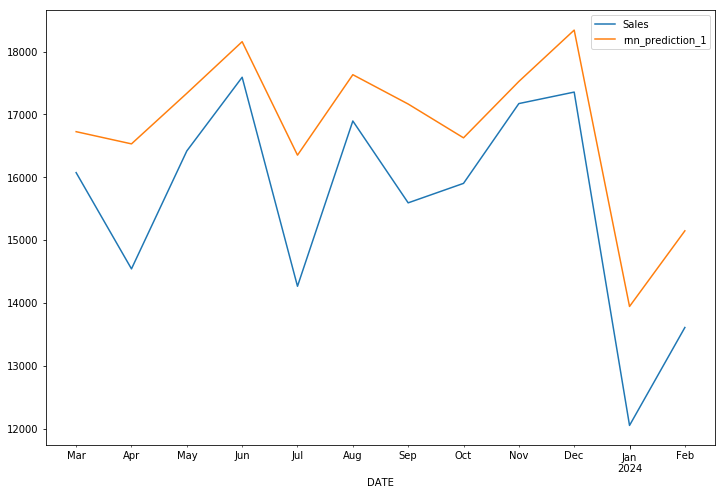

In [36]:
test.plot(figsize=(12,8))

In [37]:
error = np.sqrt(mean_squared_error(test['Sales'],test['rnn_prediction_1']))
print(f'RNN RMSE Error: {error:11.10}')

RNN RMSE Error: 1306.914373


In [64]:
## RNN Improvement

# define model
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(n_input, n_features),return_sequences=True))
model.add(LSTM(32, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [65]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 12, 64)            16896     
_________________________________________________________________
lstm_11 (LSTM)               (None, 32)                12416     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 29,345
Trainable params: 29,345
Non-trainable params: 0
_________________________________________________________________


In [66]:
# fit model
model.fit_generator(generator,epochs=30)

Epoch 1/30
362/362 [==============================] - 12s 17ms/step - loss: 0.0190
Epoch 2/30
362/362 [==============================] - 6s 18ms/step - loss: 0.0068
Epoch 3/30
362/362 [==============================] - 6s 17ms/step - loss: 0.0081
Epoch 4/30
362/362 [==============================] - 6s 17ms/step - loss: 0.0062: 0s 
Epoch 5/30
362/362 [==============================] - 6s 16ms/step - loss: 0.0054
Epoch 6/30
362/362 [==============================] - 6s 16ms/step - loss: 0.0047
Epoch 7/30
362/362 [==============================] - 6s 16ms/step - loss: 0.0034
Epoch 8/30
362/362 [==============================] - 6s 16ms/step - loss: 0.0025
Epoch 9/30
362/362 [==============================] - 6s 16ms/step - loss: 0.0031
Epoch 10/30
362/362 [==============================] - 6s 16ms/step - loss: 0.0032
Epoch 11/30
362/362 [==============================] - 6s 16ms/step - loss: 0.0021
Epoch 12/30
362/362 [==============================] - 6s 17ms/step - loss: 0.0021: 0s - 


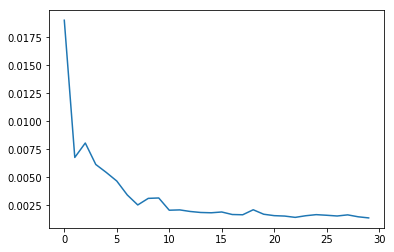

In [71]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [72]:
test_predictions = []

first_eval_batch = train_scaled[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [73]:
# convert to get true prediction
true_predictions = scaler.inverse_transform(test_predictions)

In [76]:
test['rnn_prediction_2'] = true_predictions

In [77]:
error = np.sqrt(mean_squared_error(test['Sales'], test['rnn_prediction_2']))
print(f'RNN RMSE Error: {error:11.10}')

RNN RMSE Error: 1472.584467


<a name="4"></a>
## 4 - Conclusion

Following are Model and RMSE(Root mean square root)

- Holt Winters    1144.924003
- ARIMA           1697.764636
- SARIMA          3316.509326
- RNN Model 1     1306.914373
- RNN Model 2     1472.584467


Therefore we can conclude that for are test data, Holt Winters gives best predictions

In [78]:
# FUTURE FORECAST
final_model = ExponentialSmoothing(df['Sales'],trend='mul',seasonal='mul',seasonal_periods=12).fit()

In [79]:
forecast_predictions = final_model.forecast(12)

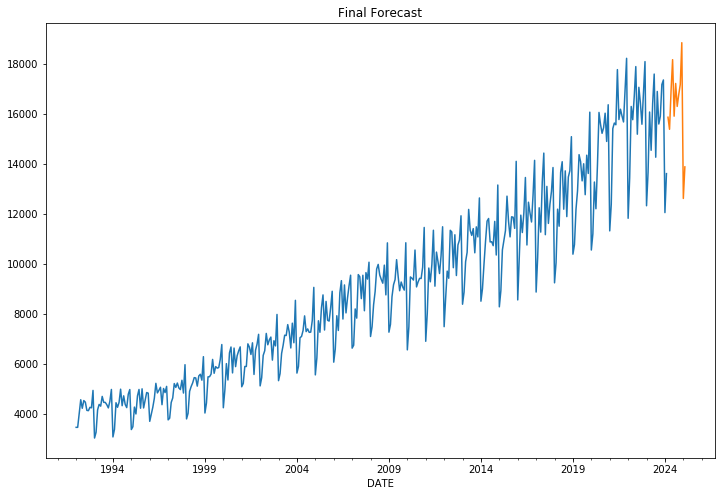

In [82]:
title = "Final Forecast"
df["Sales"].plot(figsize=(12,8),title=title)
forecast_predictions.plot()